<a href="https://colab.research.google.com/github/HoanChan/TableVision/blob/main/borderless_table_detection.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [28]:
#@title Cài đặt kiểm tra môi trường và tải mã nguồn để lấy dữ liệu
# Kiểm tra hiện tại có phải đang ở trong colaboratory hay không
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !git clone https://github.com/HoanChan/TableVision.git TableVision
    %cd TableVision
else:
    print("Running on Local")
prePath = "/content/TableVision/" if IN_COLAB else ""

Running on Local


In [29]:
from utils.ocr import *

detector = init_VietOCR()

Đã cài đặt thư viện nhận diện văn bản
Model weight /tmp/vgg_seq2seq.pth exsits. Ignore download!


<Figure size 1000x2000 with 0 Axes>

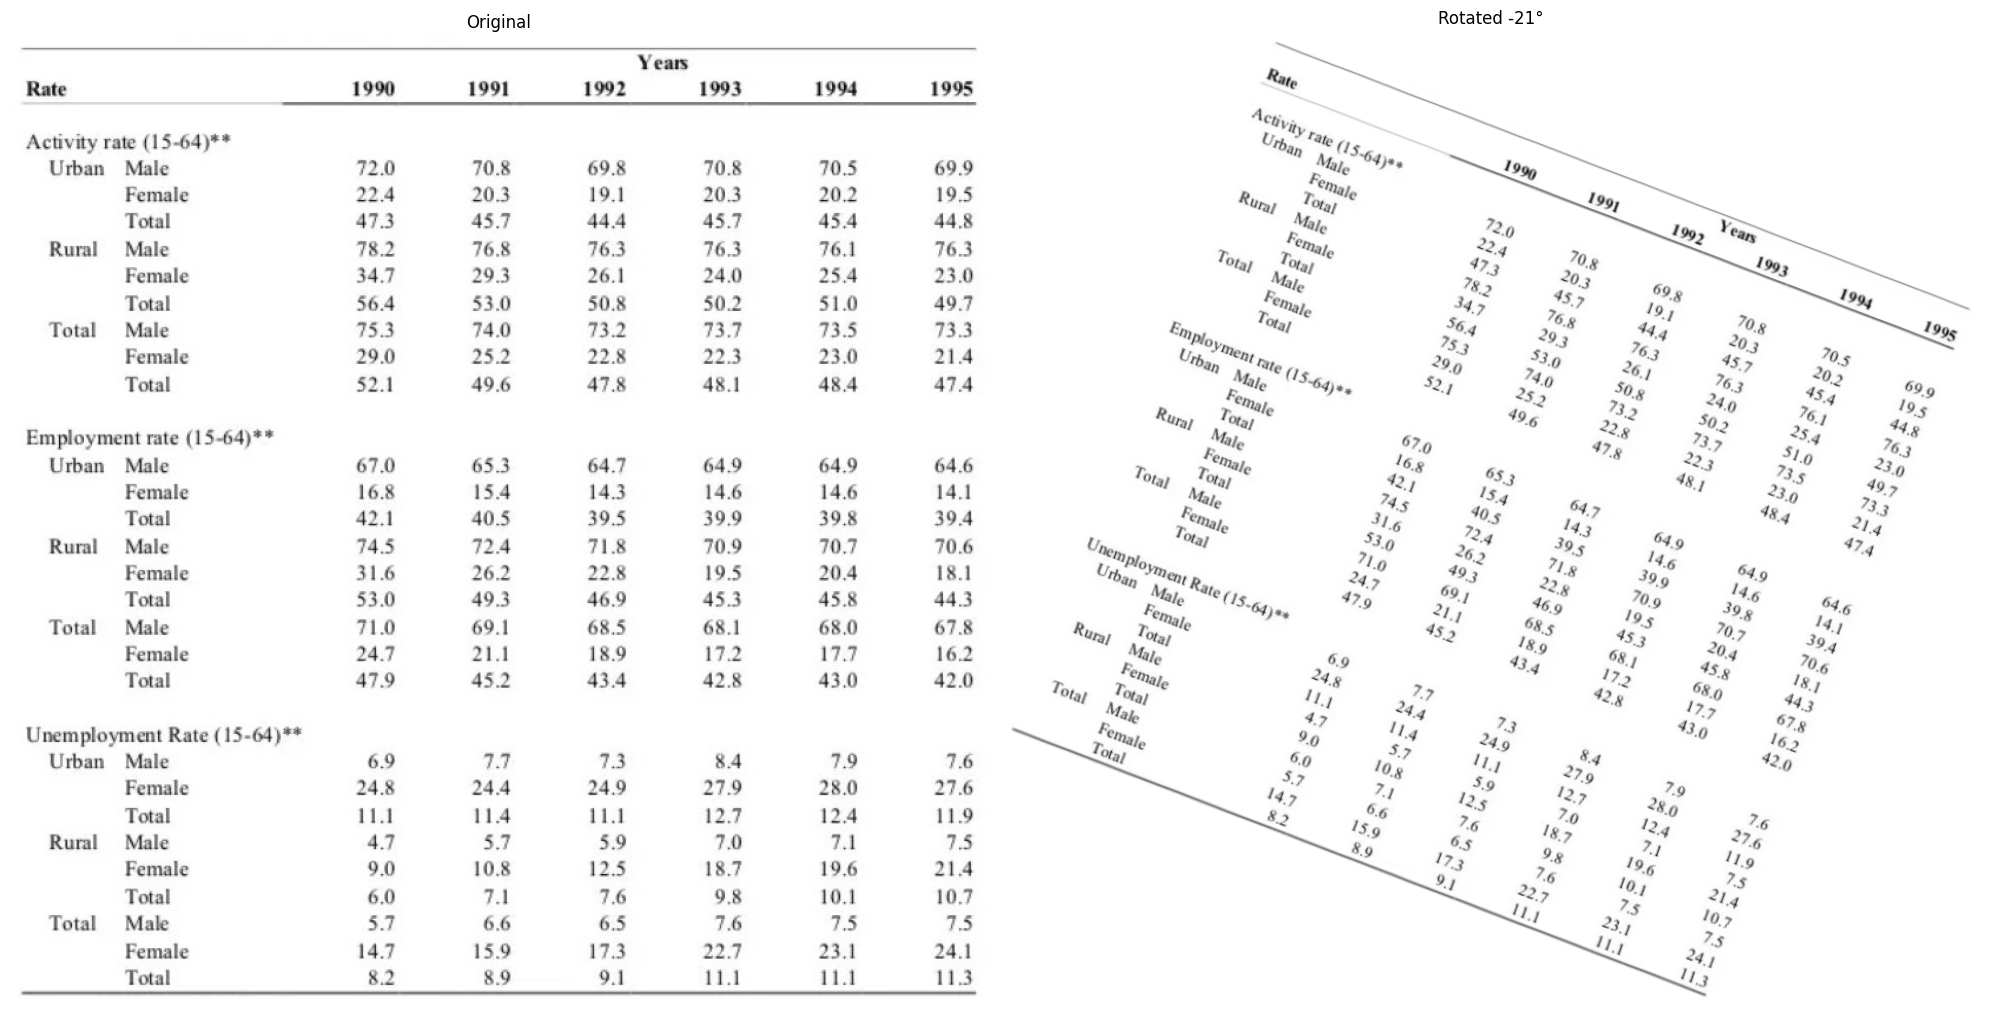

In [30]:
from utils.cv import *
from matplotlib import pyplot as plt
import cv2
import random
from detection.borderless_table_detection import *

image_path = prePath + "sample/no4.jpg"
image = cv2.imread(image_path)
angle = random.randint(-30, 30)
rotated_image = rotate_image(image, angle)
# thiết lập kích thước hiển thị ảnh
plt.figure(figsize=(10, 20))
# hiển thị ảnh gốc và ảnh đã xoay
display_images_with_labels([(image, "Original"), (rotated_image, f"Rotated {str(angle)}°")], (1, 2), show_axis=False)

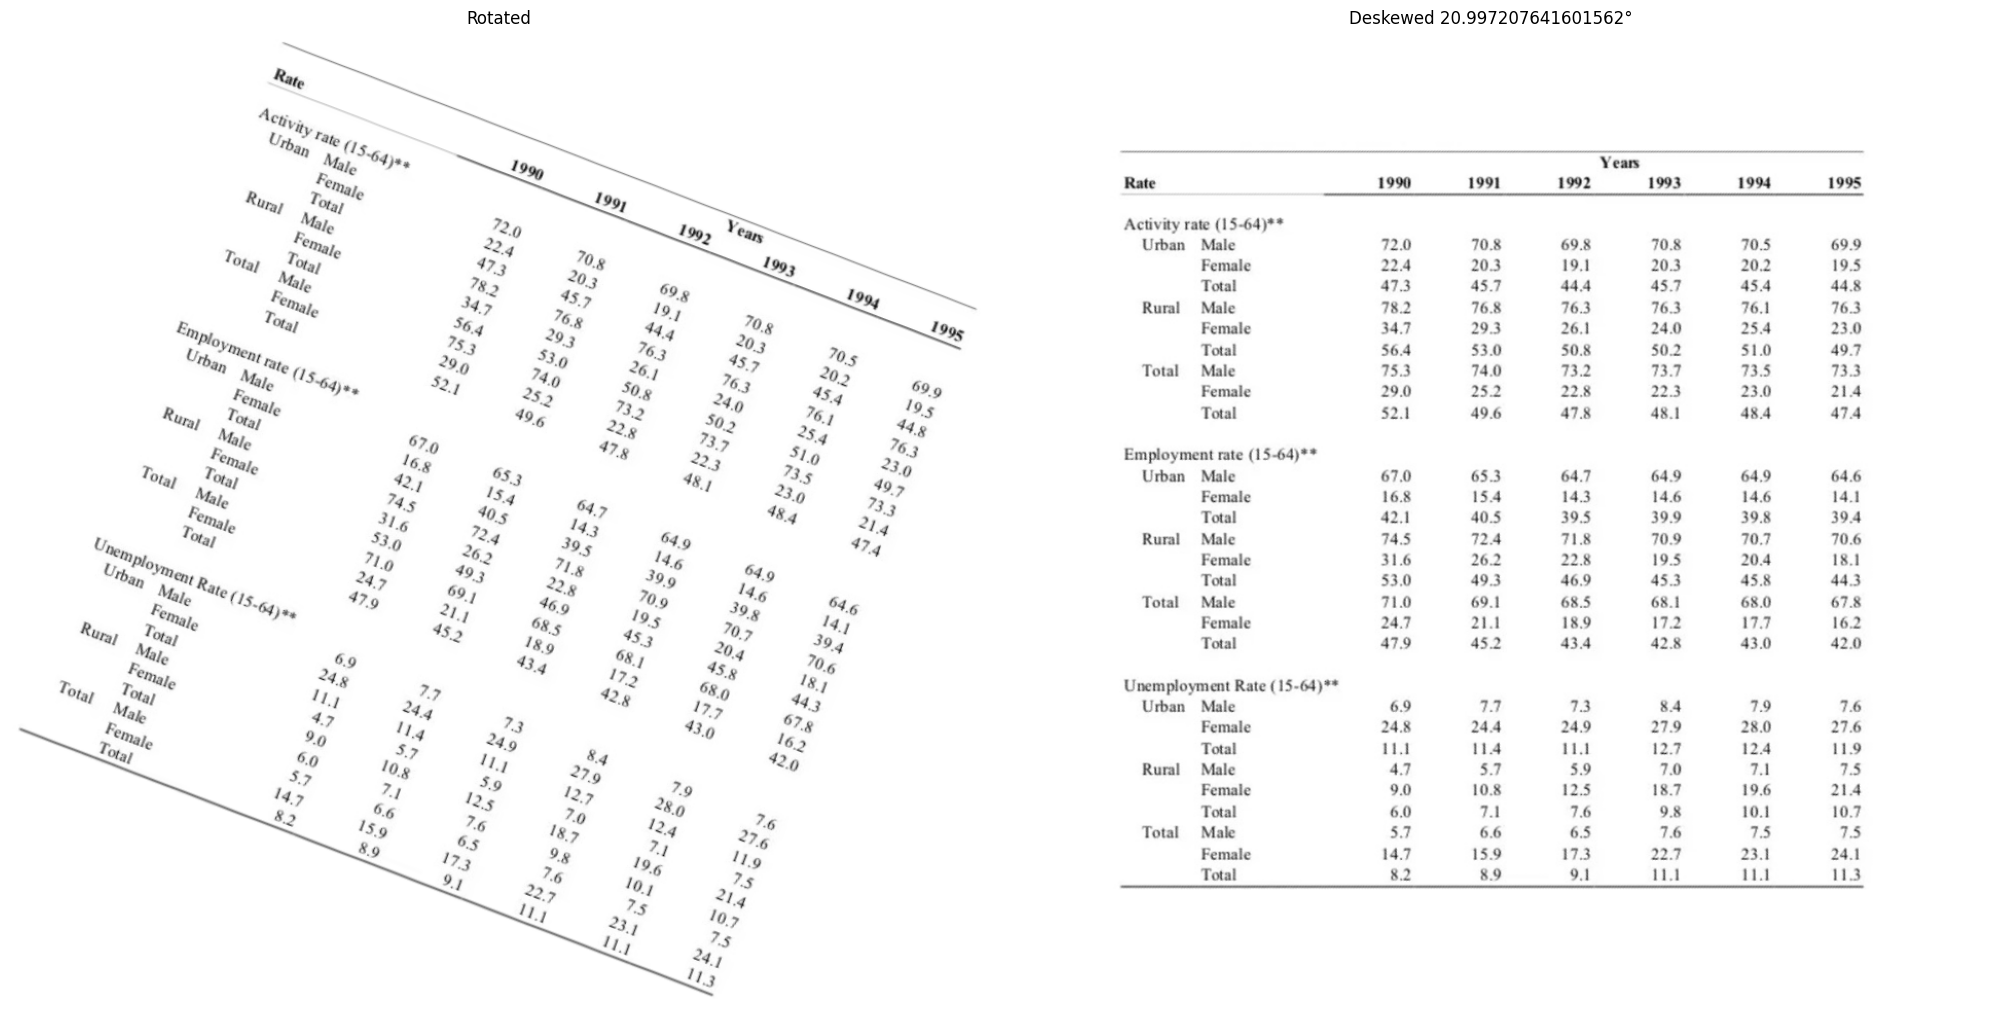

In [31]:
image_deskew, calc_angle = deskew_image(rotated_image)
display_images_with_labels([(rotated_image, "Rotated"), (image_deskew, f"Deskewed {str(calc_angle)}°")], (1, 2), show_axis=False)

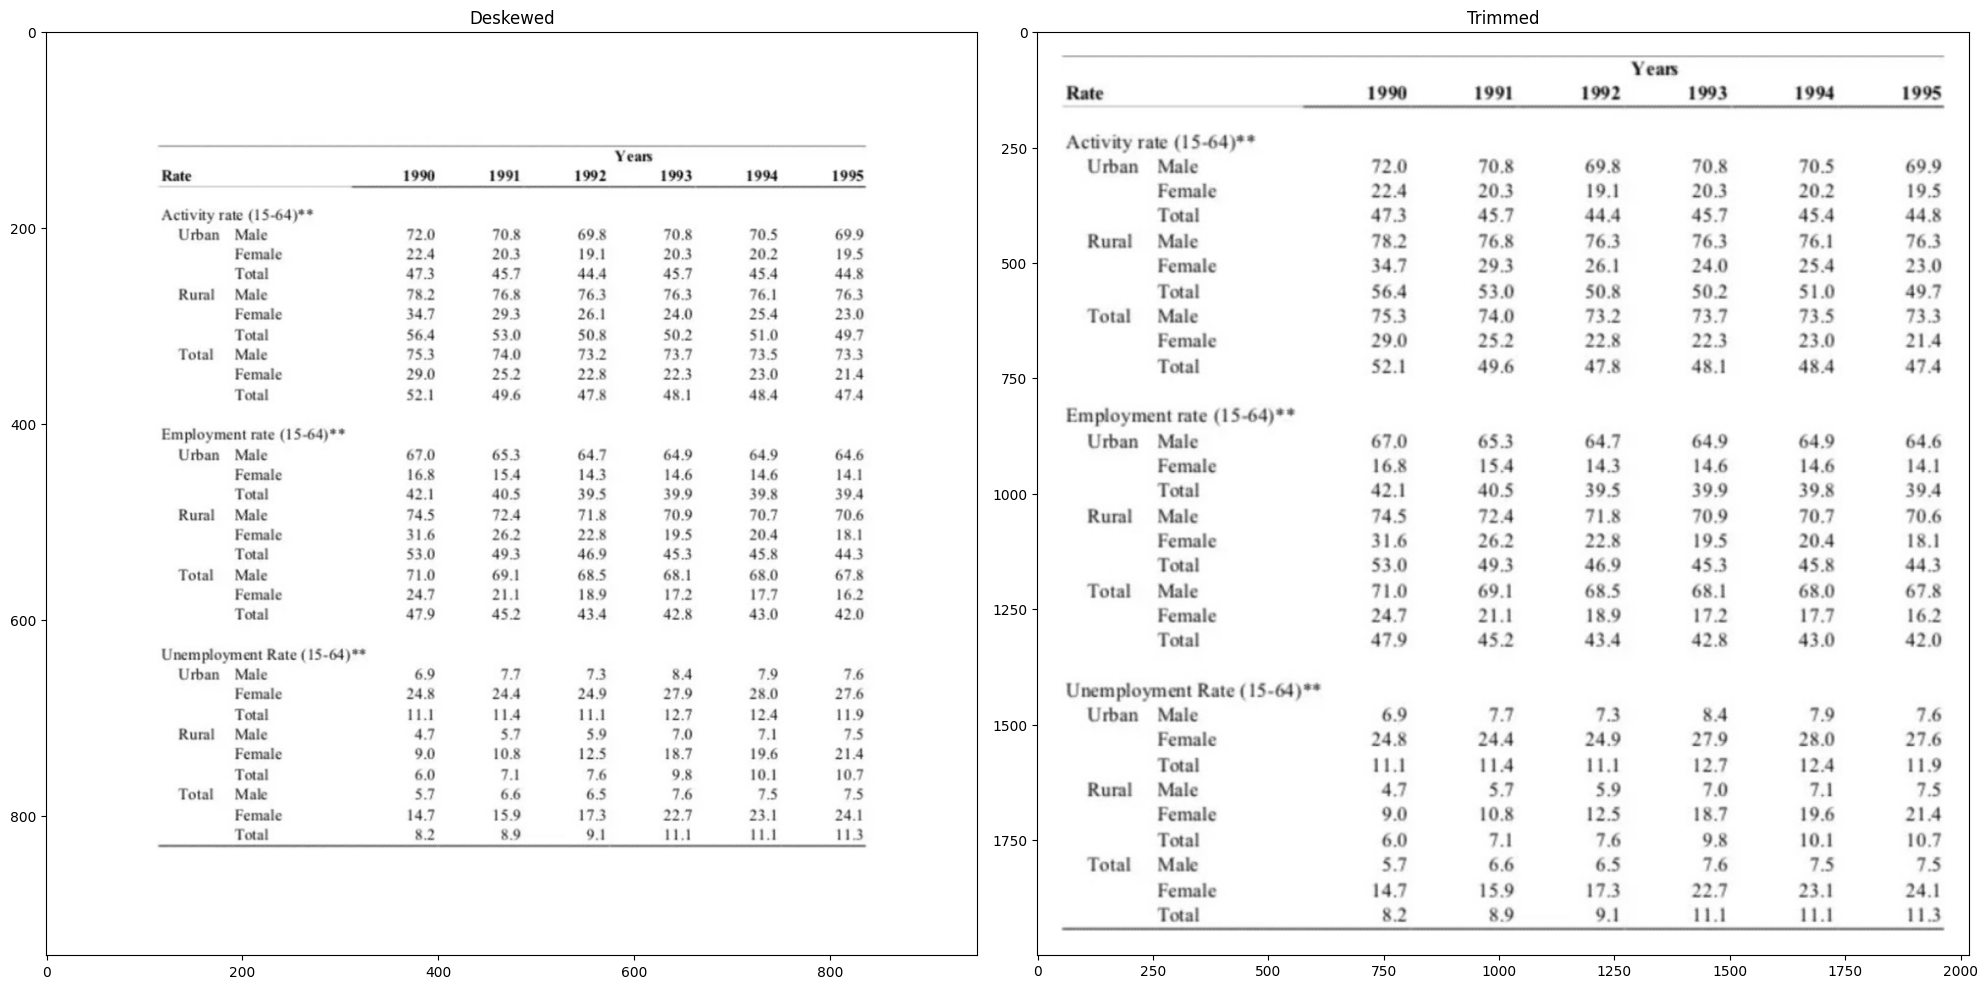

In [32]:
image_ok = trim_white(image_deskew)
display_images_with_labels([(image_deskew, "Deskewed"), (image_ok, "Trimmed")], (1, 2), show_axis=True)

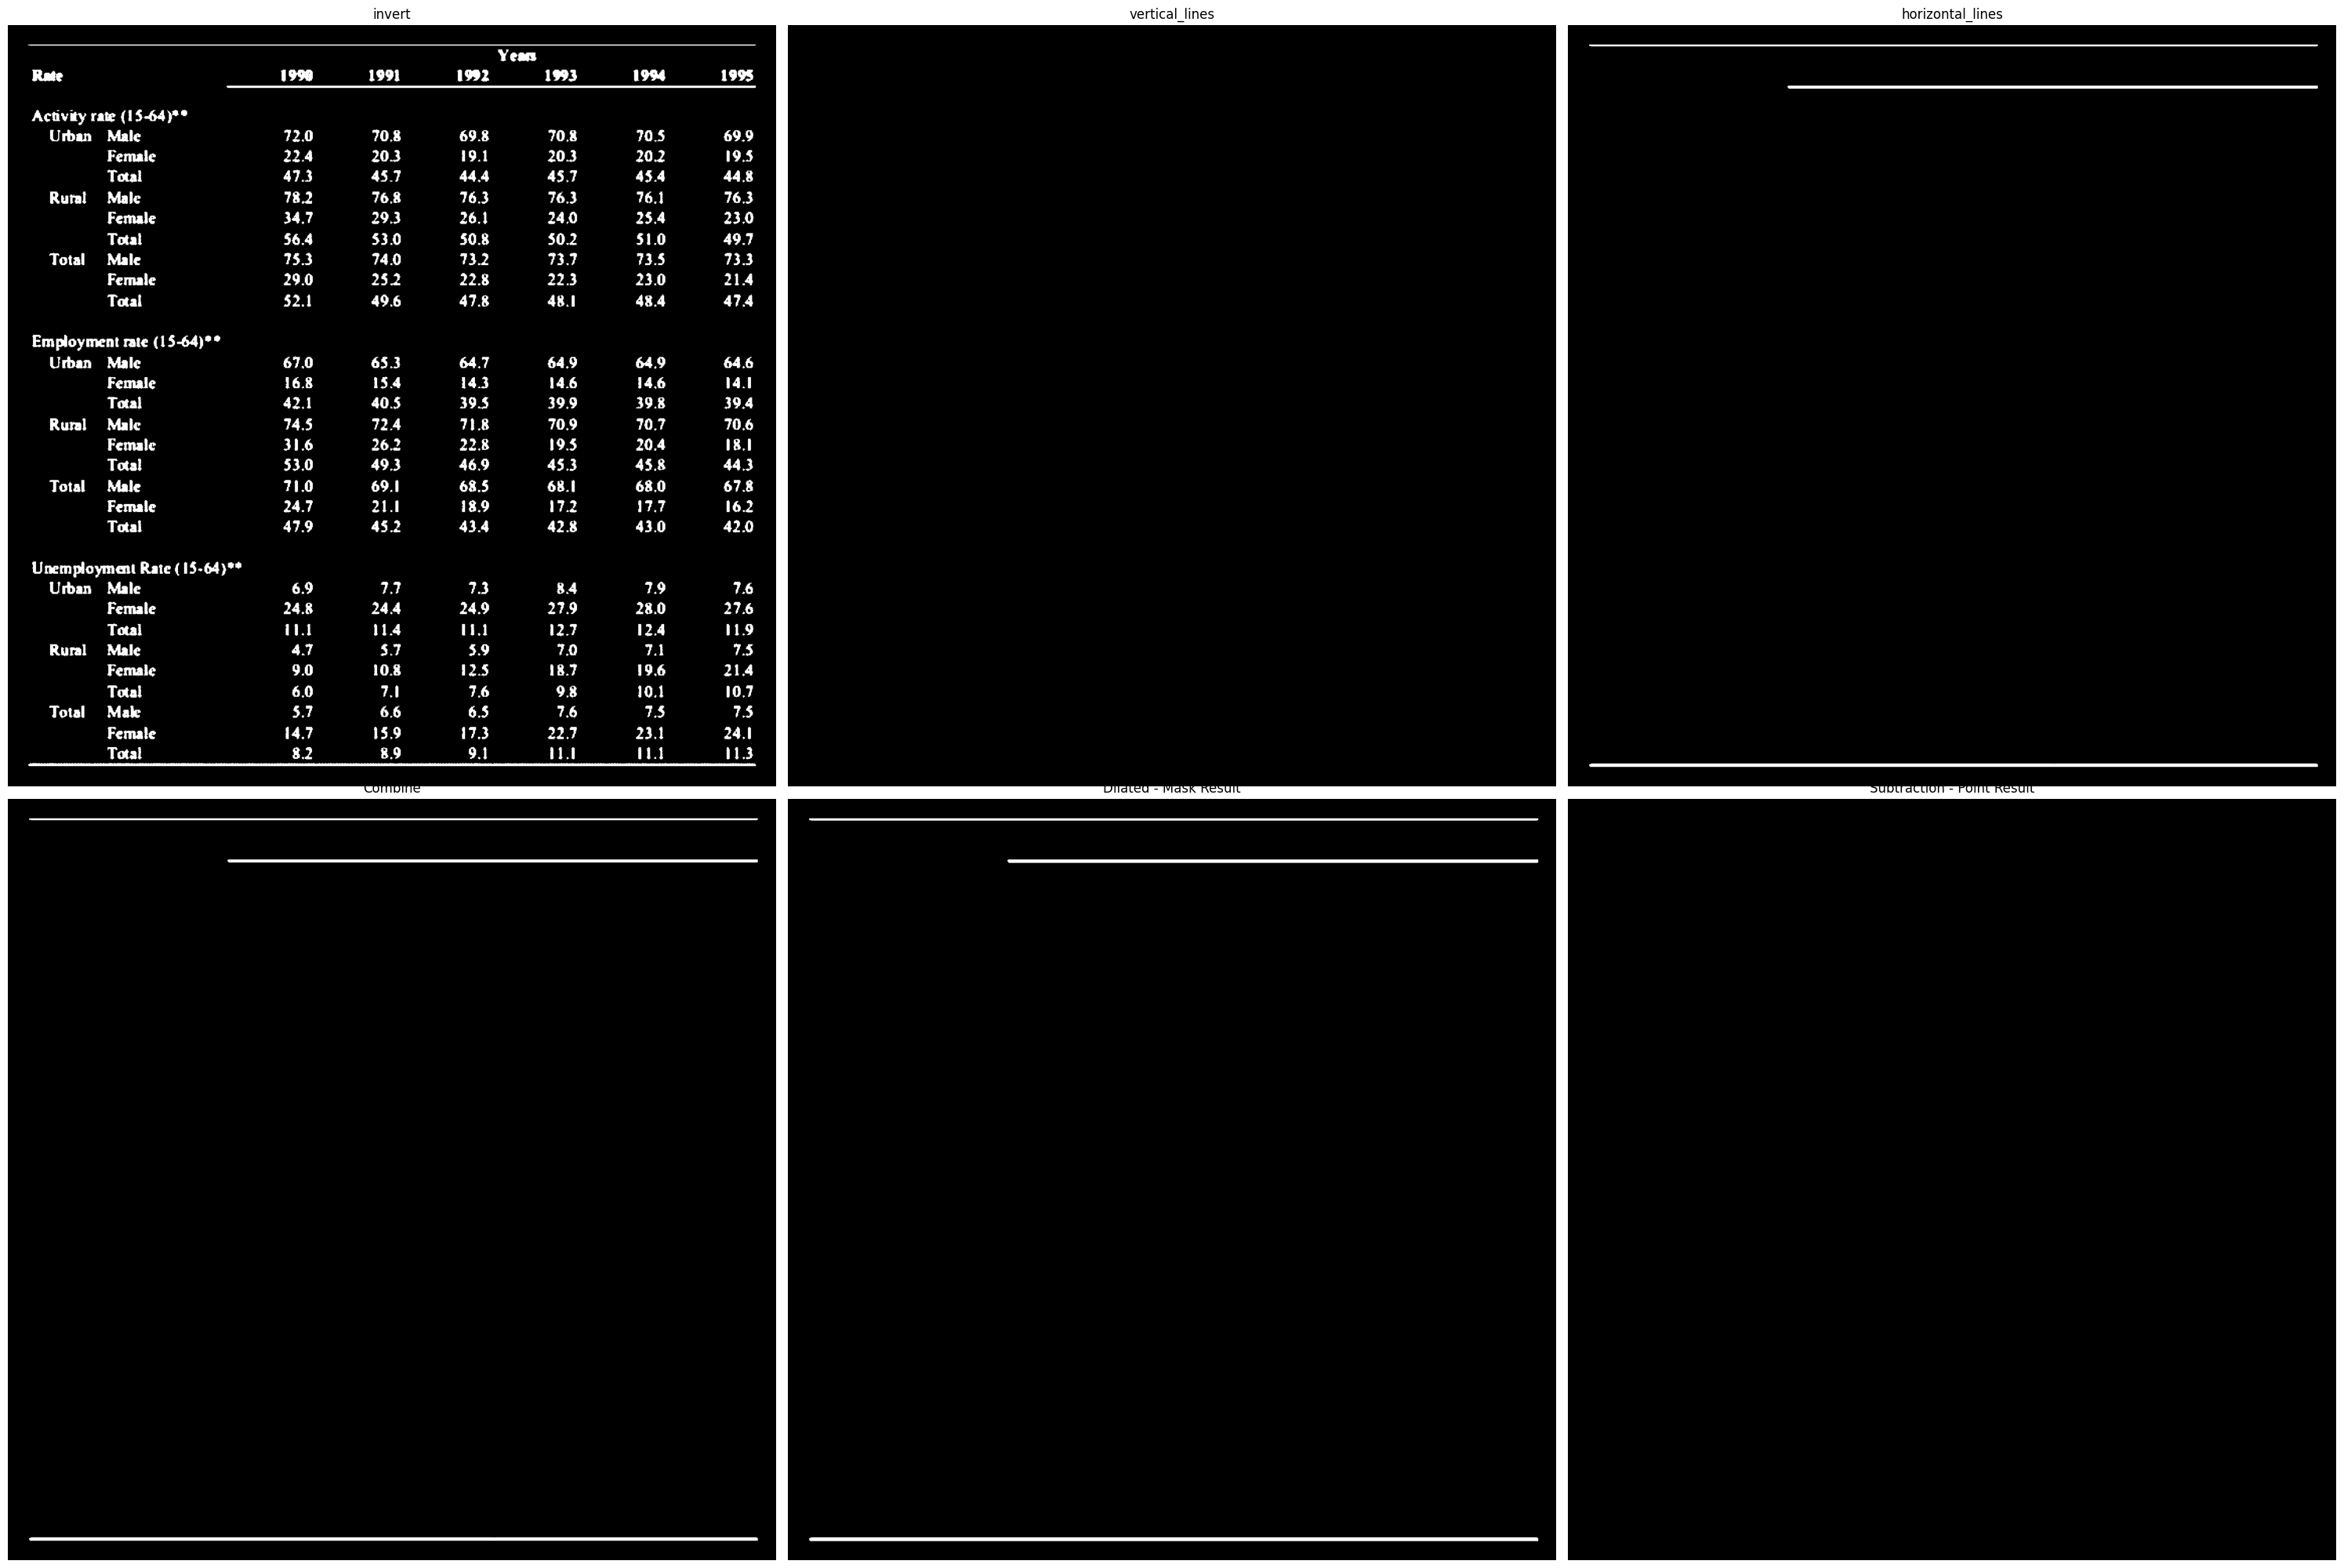

In [33]:
mask, dots, outImag = find_Lines(image_ok)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

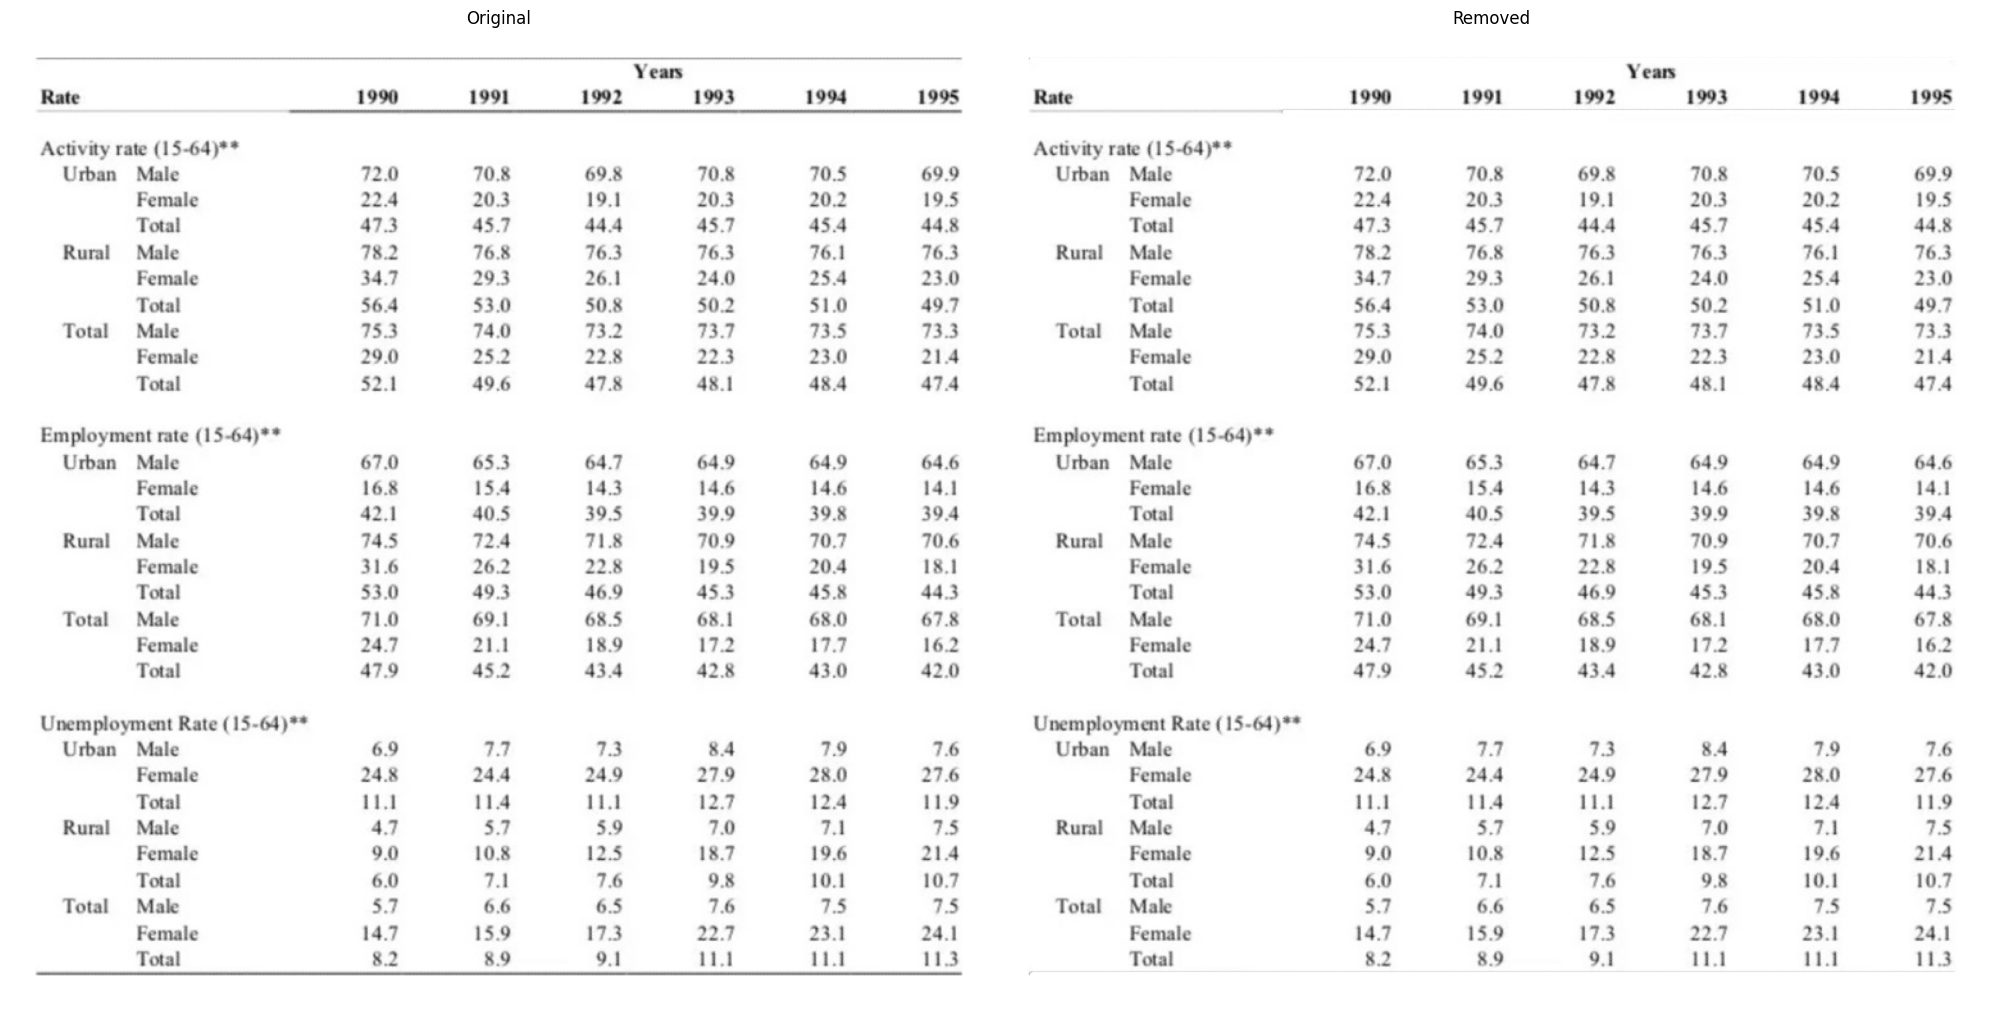

In [35]:
image_removed = remove_regions(image_ok, mask)
display_images_with_labels([(image_ok, "Original"), (image_removed, "Removed")], (1, 2), show_axis=False)

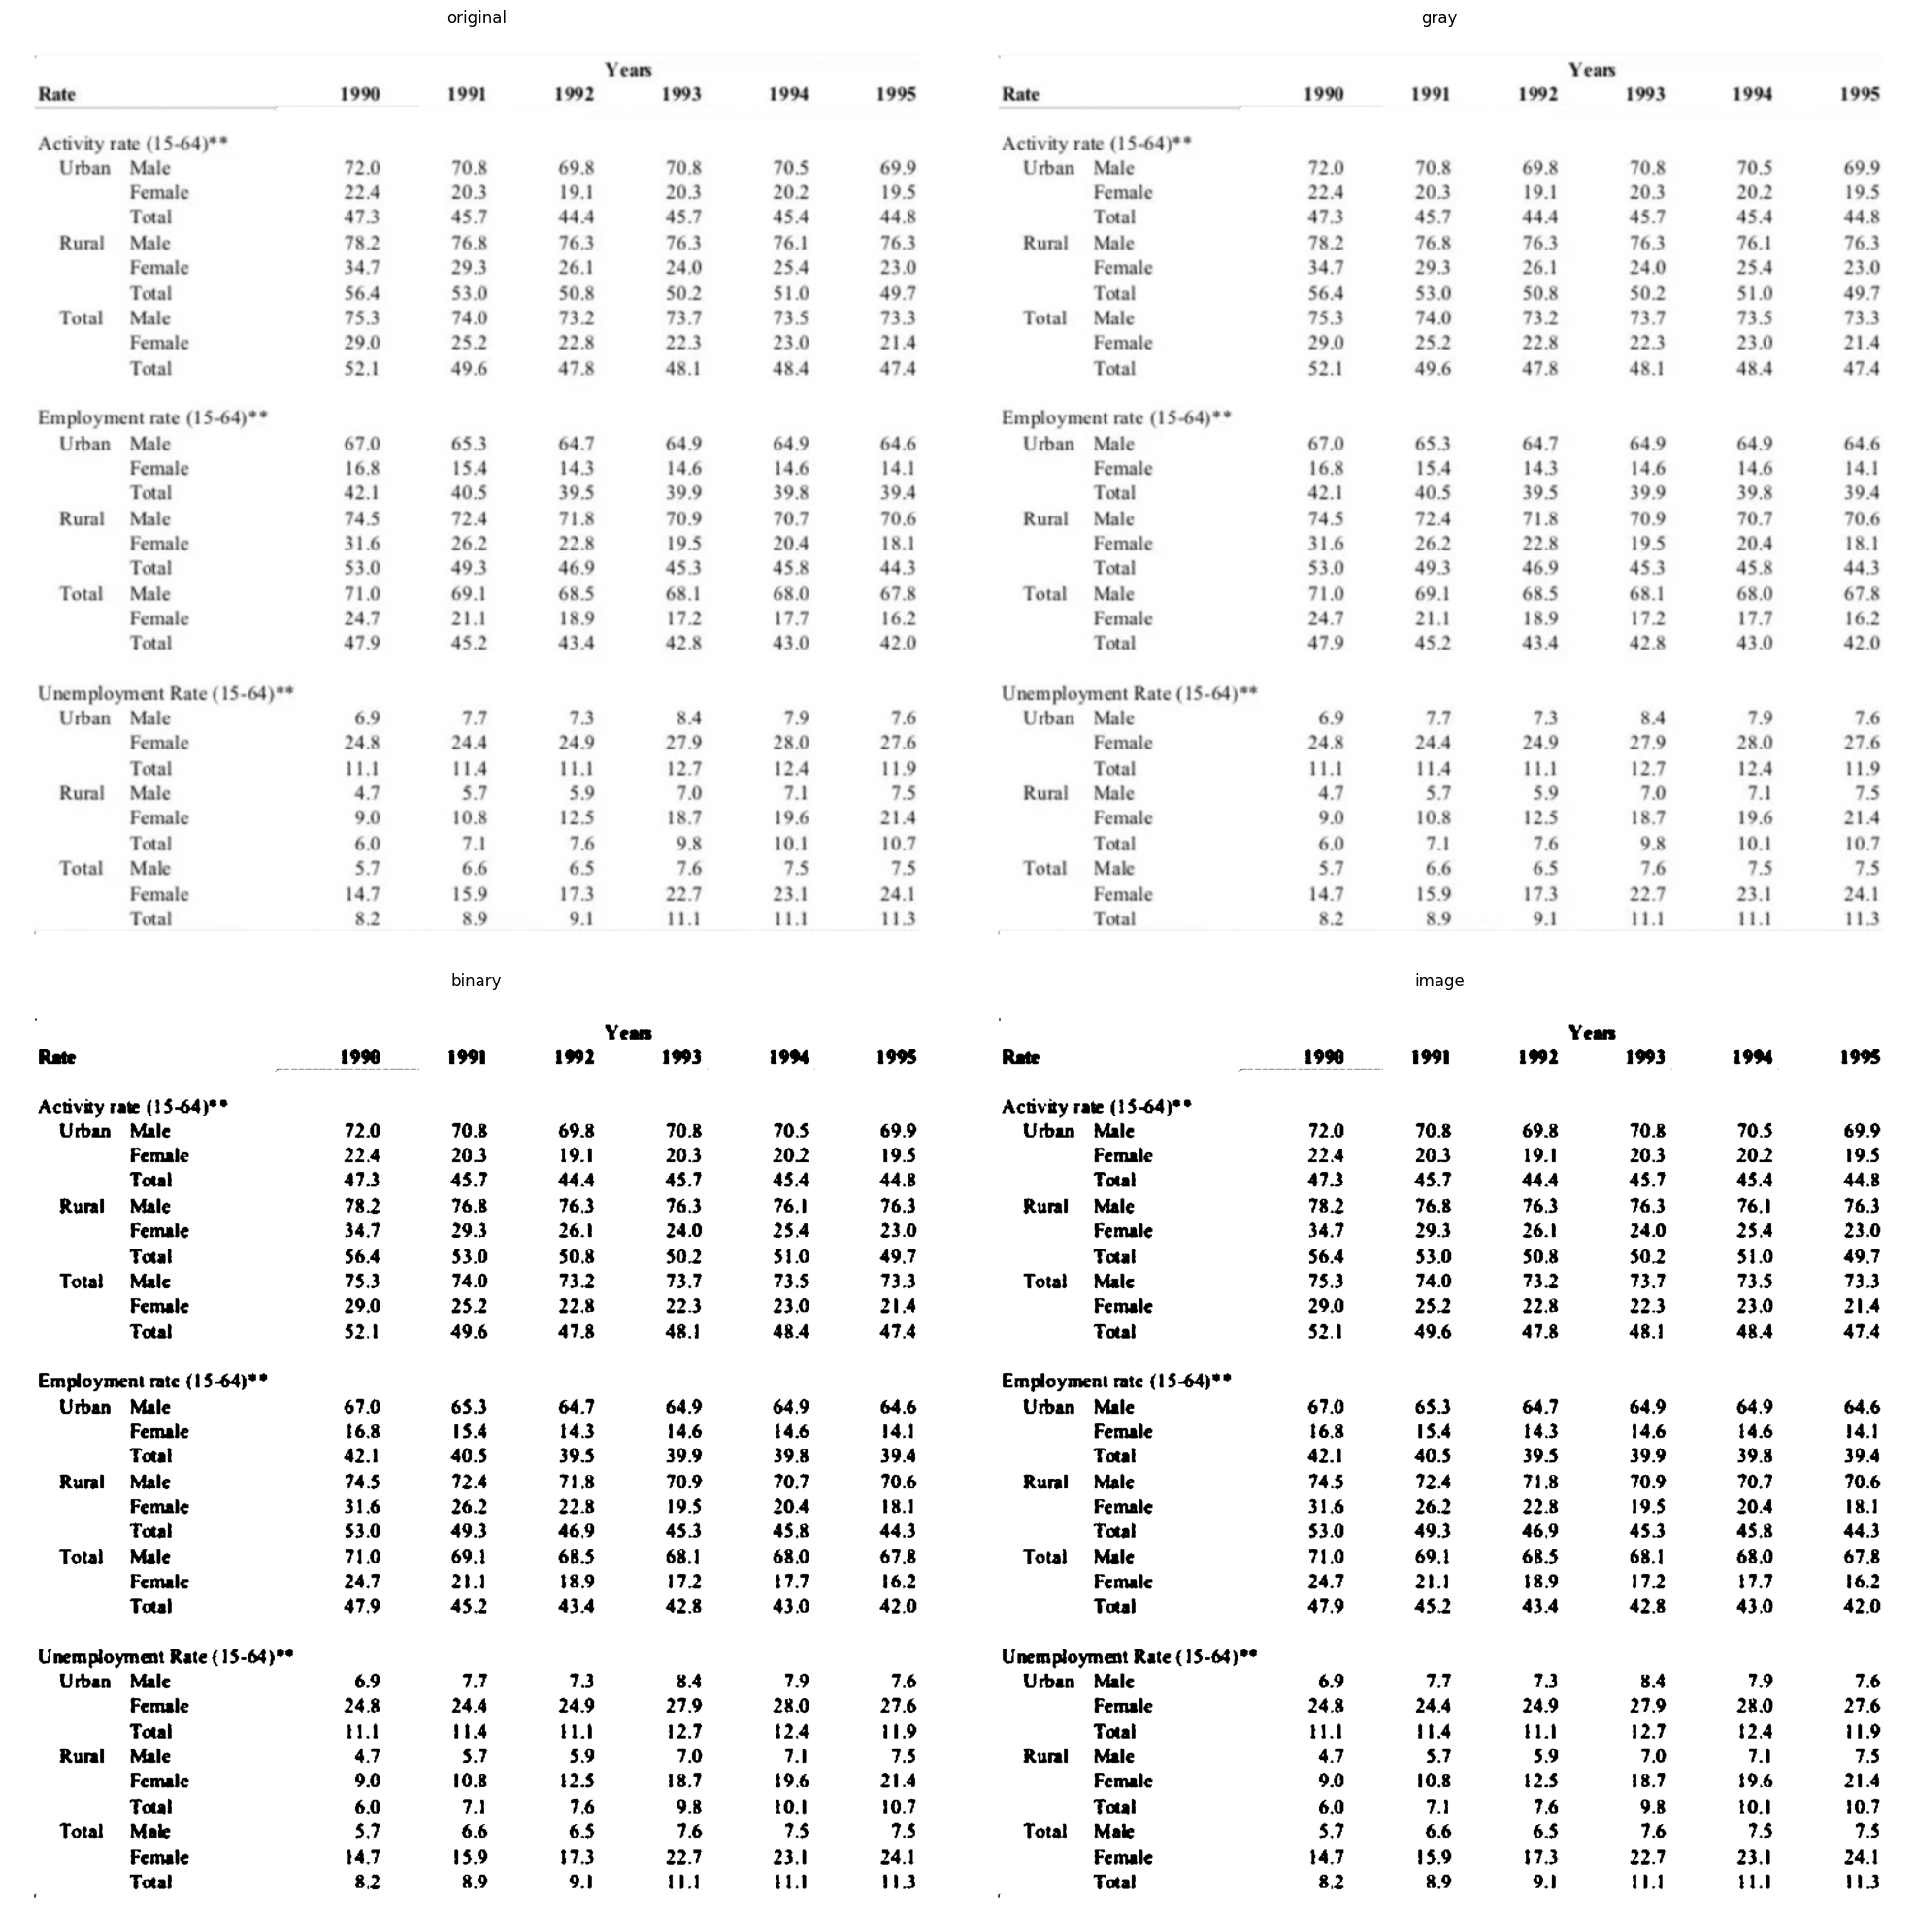

In [8]:
from detection.border_table_detection import *
outPre, image_pre = preProcessing(image_removed)
display_images_with_labels(outPre, (2, 2), show_axis=False)

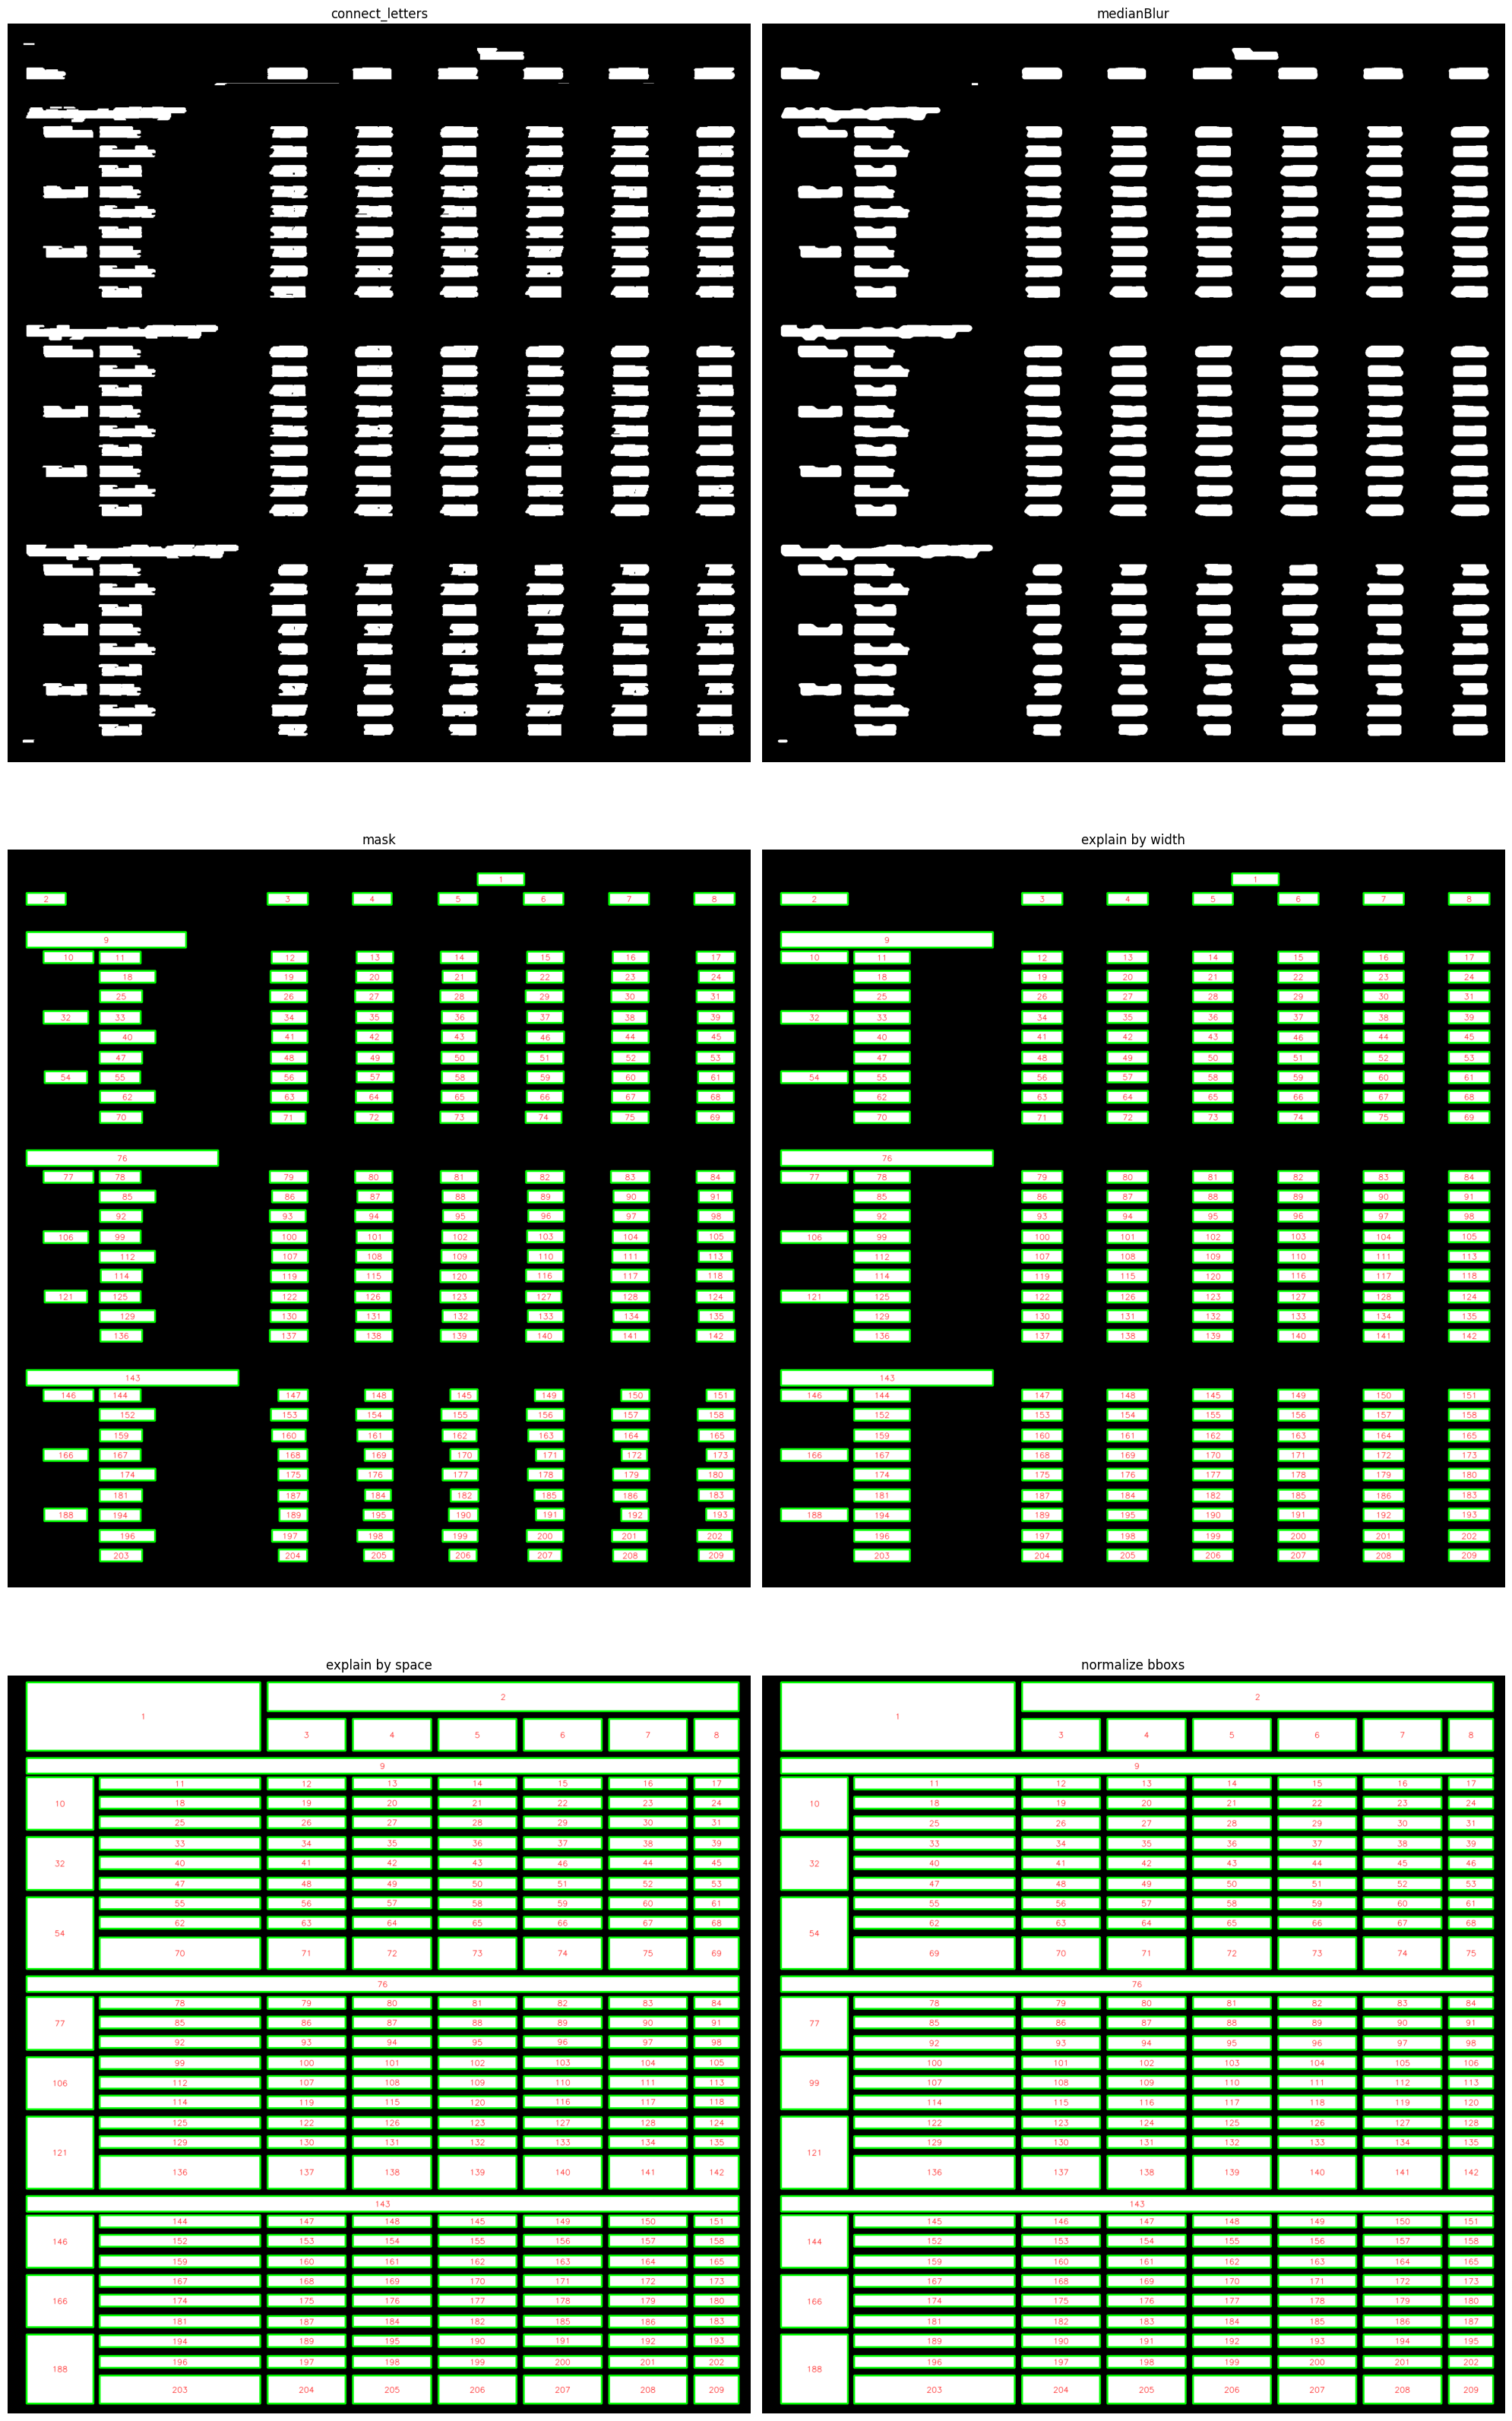

In [26]:
bboxs, mask, outImag = find_Cells(image_pre)
num_cols = 2
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), size=(10, 11), show_axis=False)

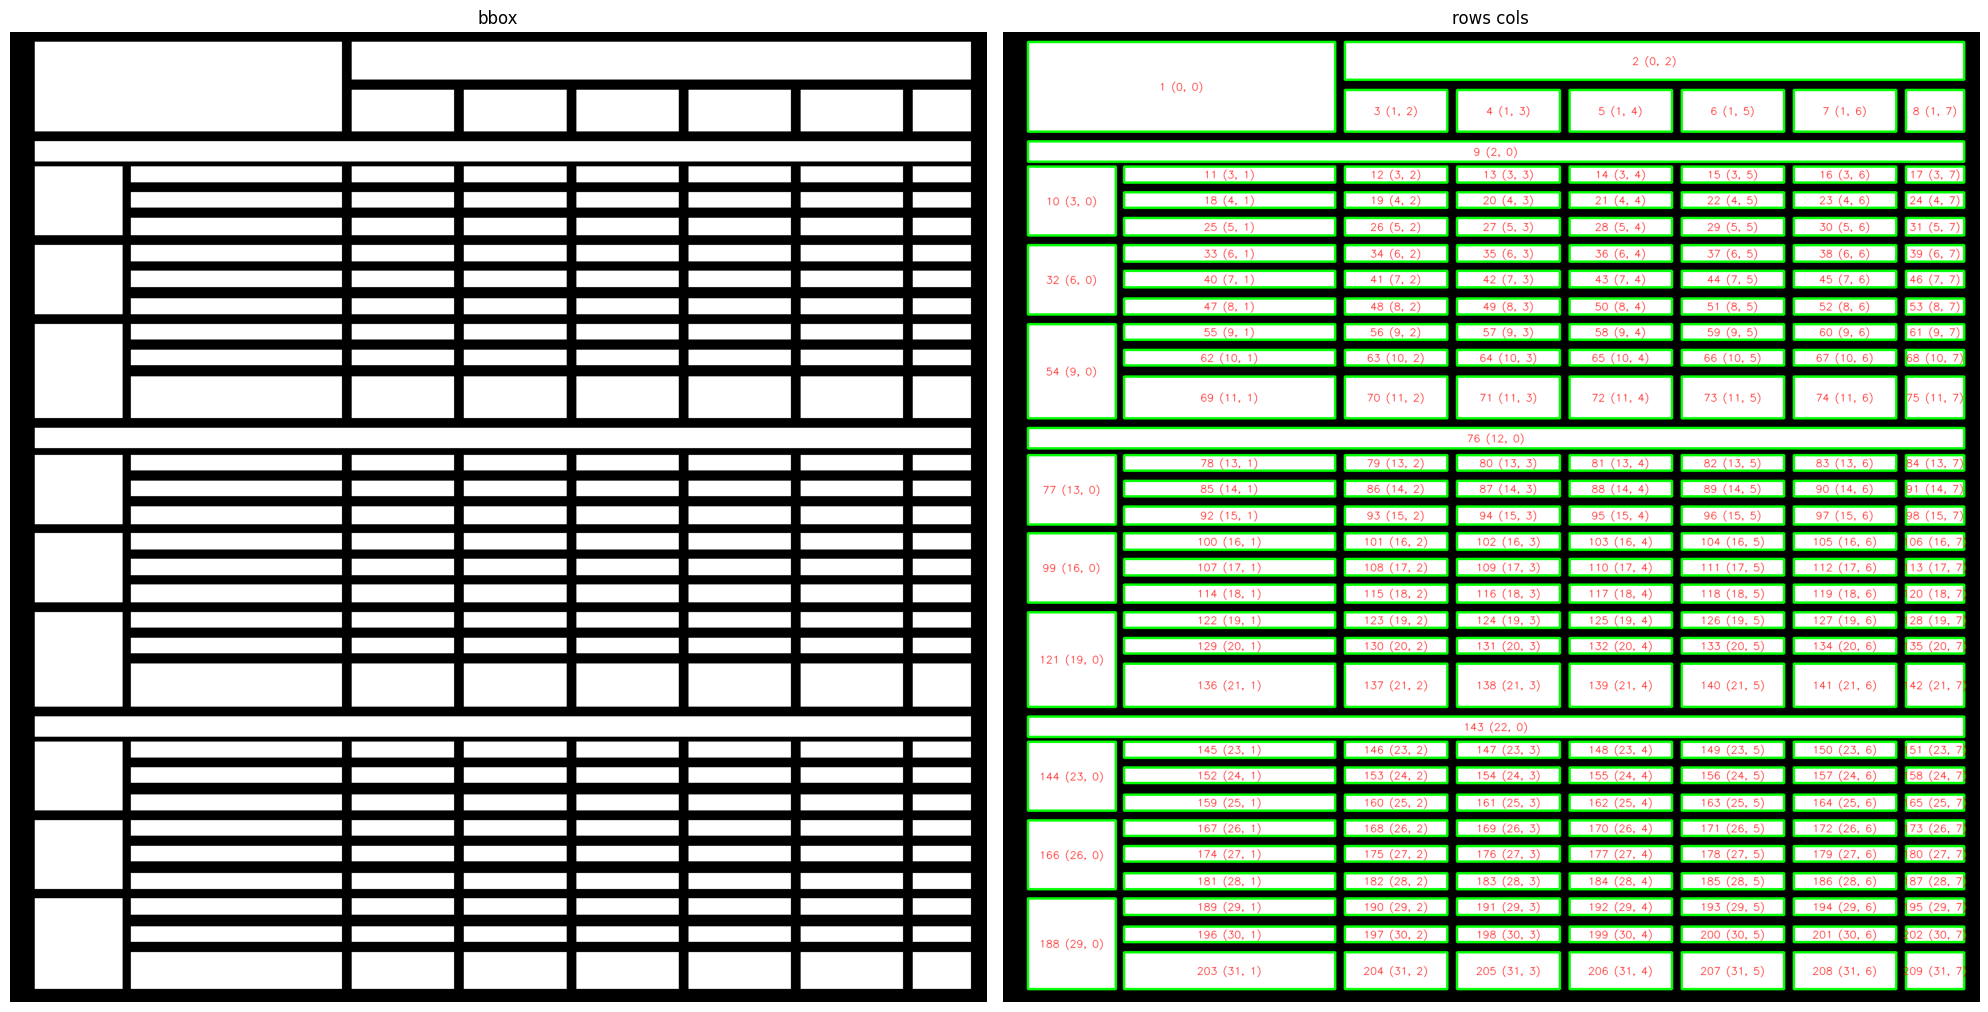

In [10]:
boxs = bboxs
cols = split_box_rows_columns(boxs, mode = 'col')       
rows = split_box_rows_columns(boxs, mode = 'row')
box_indexs = [getbox_index(box, rows, cols) for box in boxs]
new_mask = create_mask_from_bboxs(image_pre, boxs)
img_rows_cols = draw_bboxs(new_mask, boxs, lambda x: str(x) + ' '+ str(box_indexs[x-1]))
display_images_with_labels([(mask,'bbox'),(img_rows_cols, 'rows cols')], (1, 2), show_axis=False)

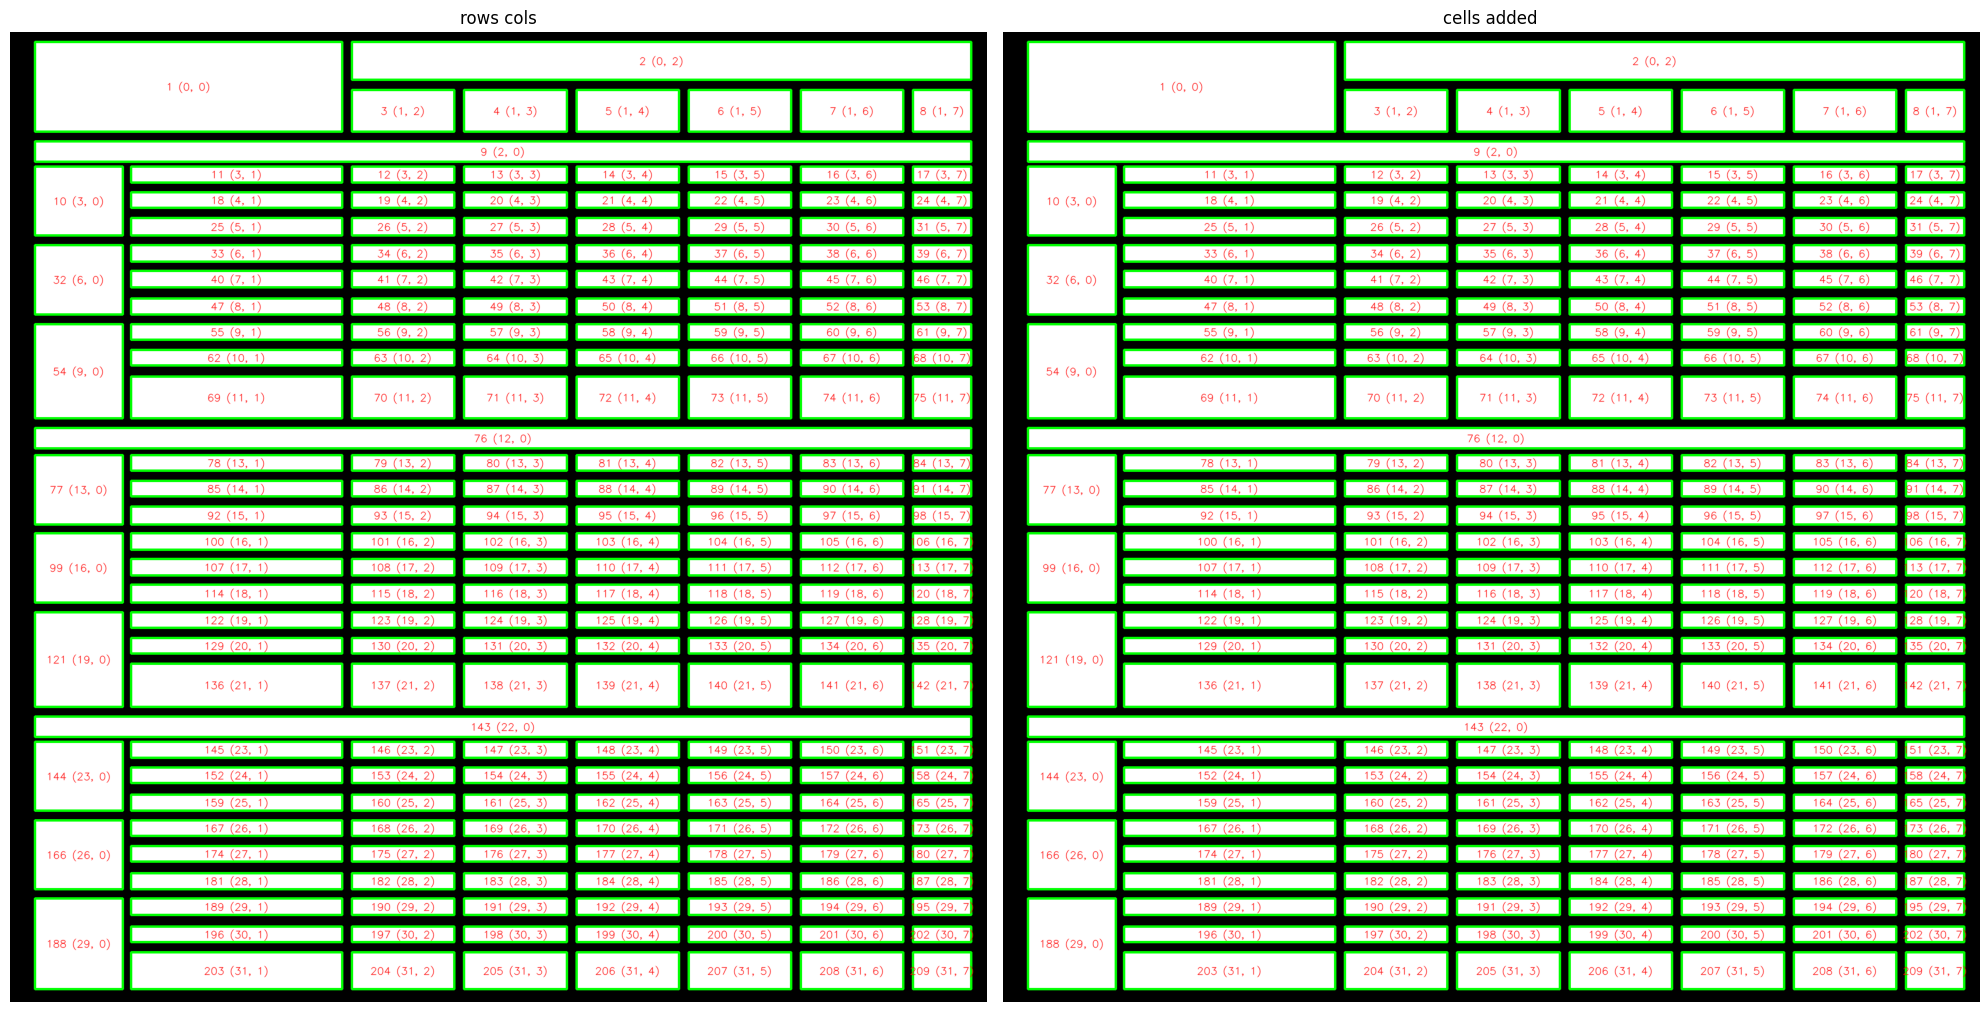

In [11]:
boxs, rows, cols, box_indexs = add_missing_cells(boxs, rows, cols, box_indexs)
new_mask = create_mask_from_bboxs(image_pre, boxs)
img_cells_added = draw_bboxs(new_mask, boxs, lambda x: str(x) + ' '+ str(box_indexs[x-1]))
display_images_with_labels([(img_rows_cols, 'rows cols'),(img_cells_added, 'cells added')], (1, 2), show_axis=False)

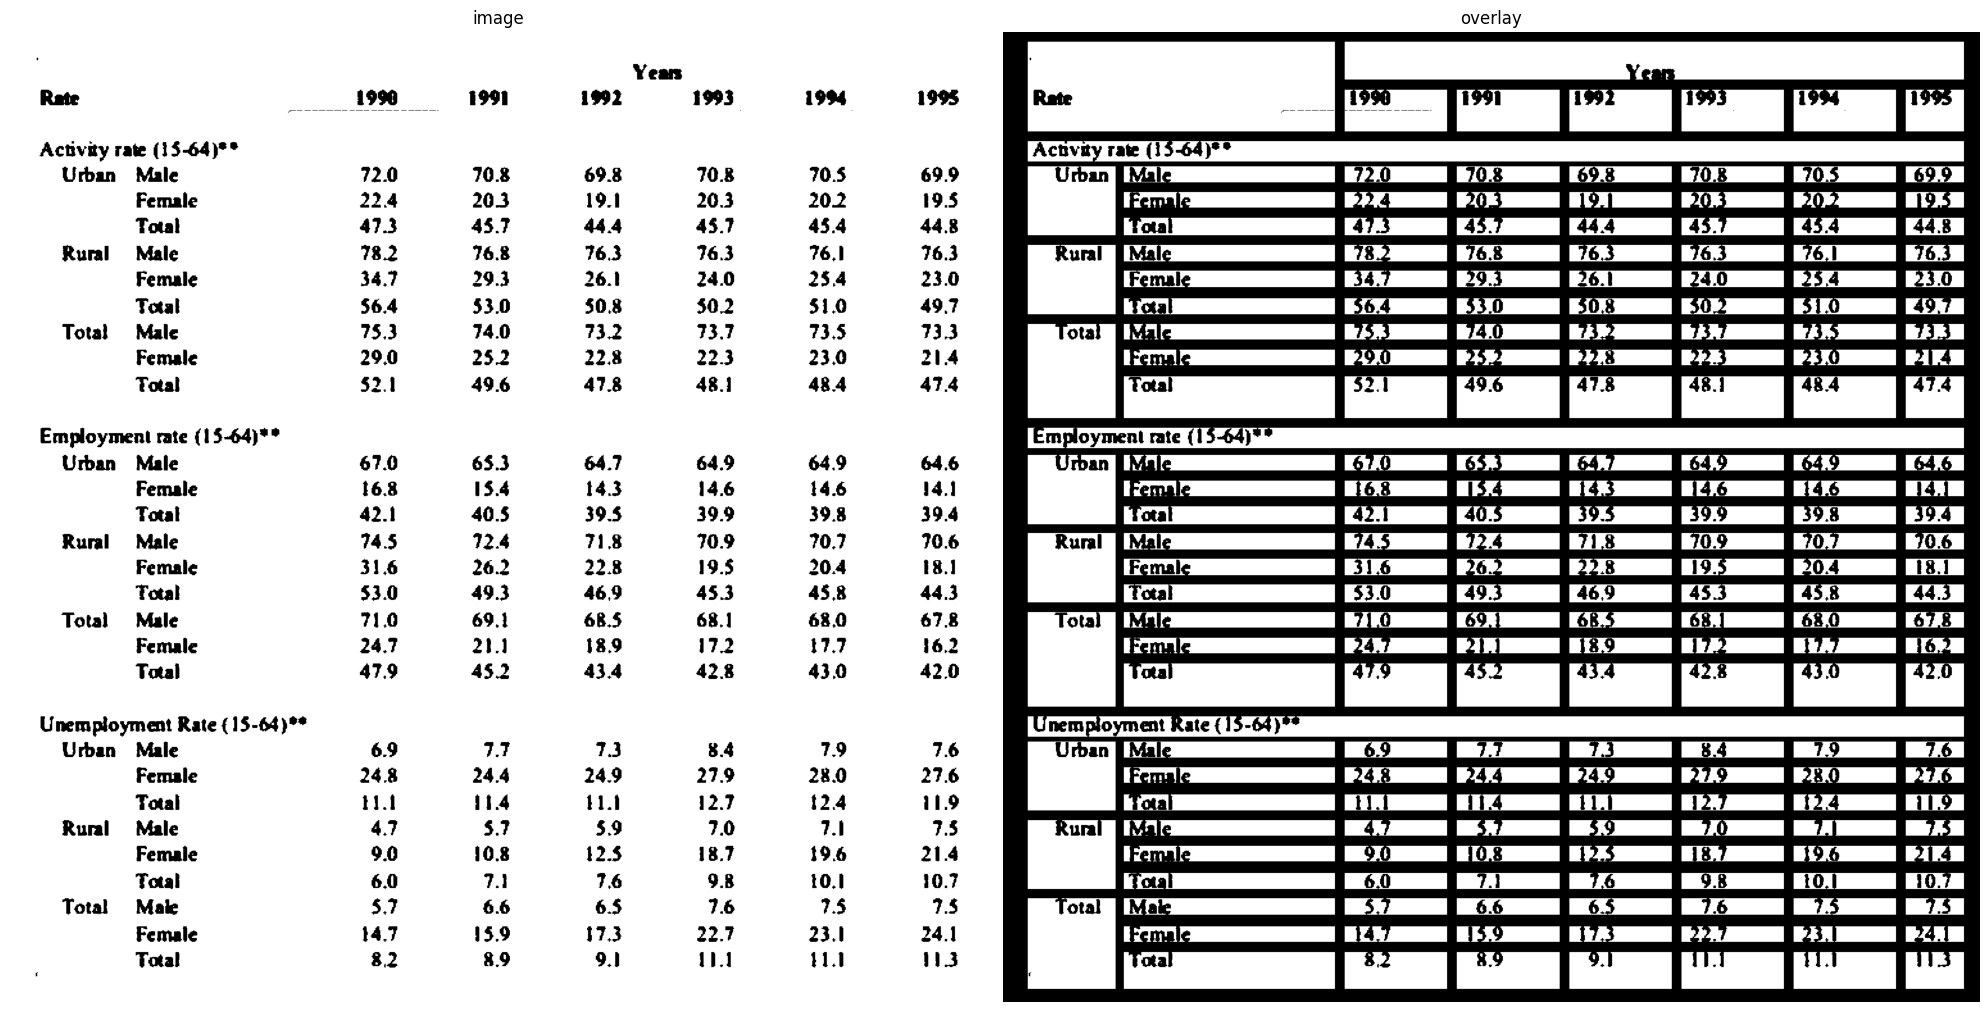

In [37]:
overlay_mask = cv2.cvtColor(new_mask, cv2.COLOR_GRAY2BGR) 
overlay_img = cv2.bitwise_and(image_pre, overlay_mask)
display_images_with_labels([(image_pre, 'image'),(overlay_img, 'overlay')], (1, 2), show_axis=False)

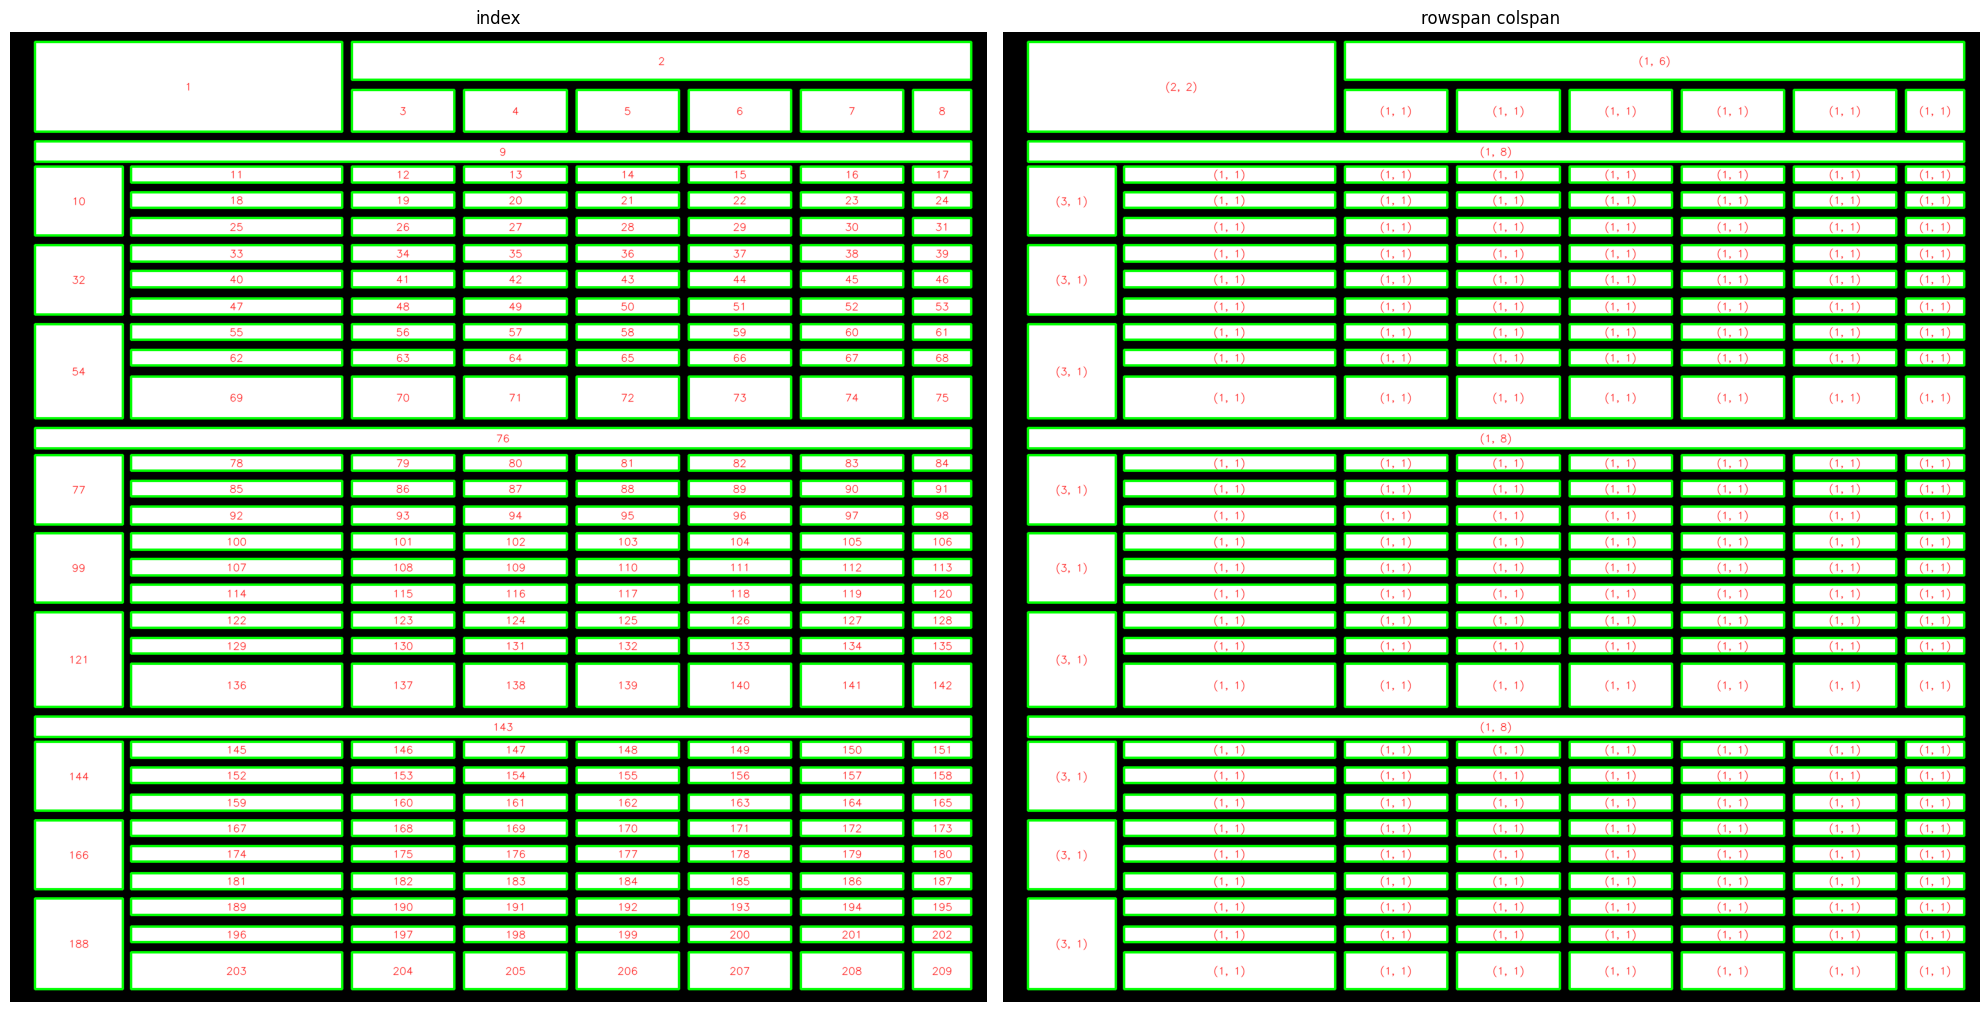

In [13]:
matrix = createSpanMatrix(rows, cols, box_indexs, bboxs)
img_index= draw_bboxs(new_mask, boxs)
img_span = draw_bboxs(new_mask, boxs, lambda x: str(matrix[box_indexs[x-1][0]][box_indexs[x-1][1]][1:]))
display_images_with_labels([(img_index, 'index'),(img_span, 'rowspan colspan')], (1, 2), show_axis=False)

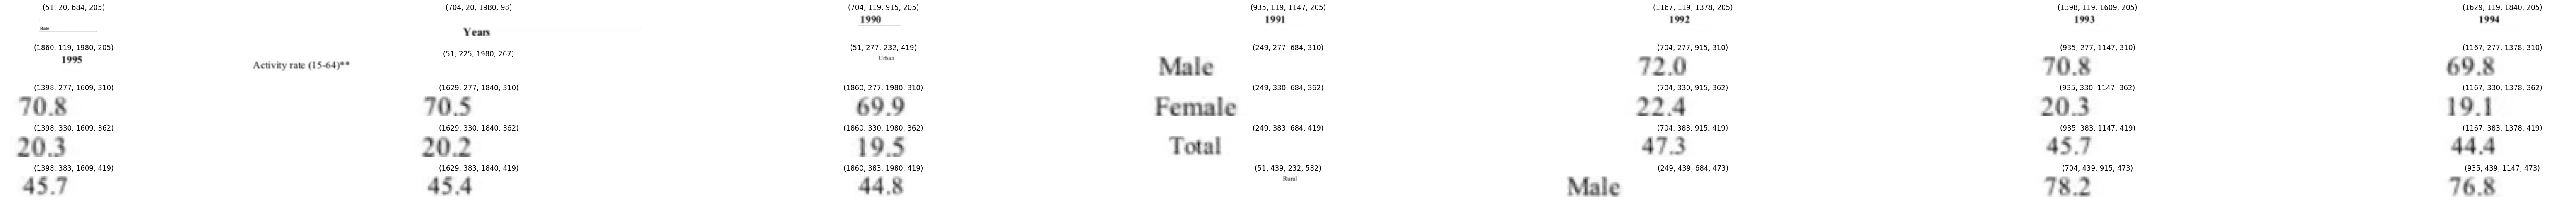

In [14]:
cells = createCells(boxs, box_indexs, matrix)
cells_imgs = createCell_img(cells, image_removed)

display_images_with_labels(cells_imgs[:35], layout = (5, 7), size = (10, 1), show_axis=False)

Male


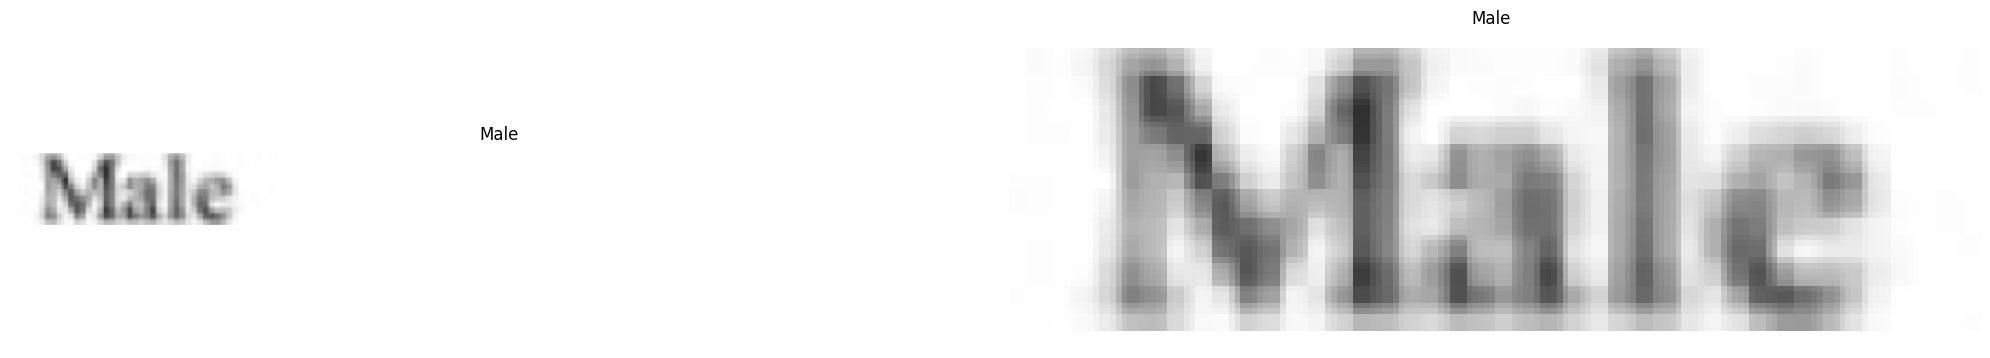

In [15]:
from utils.ocr import detectText
img = cells_imgs[54][0]
text, lines = detectText(img, detector)
print(text)
display_images_with_labels([(img, text)] + list(zip(lines, text.split('\n'))), (1, len(lines)+1), show_axis=False)

In [16]:
texts = []
for cell in cells_imgs:
  img, bbox = cell
  text, lines = detectText(img, detector)
  texts += [text]

print(texts, sep='\n')

['Rate', 'Years', '1990', '1991', '1992', '1993', '1994', '1995', 'Activity rate (15-64)', 'Urban', 'Male', '72.0', '70.8', '69.8', '70.8', '70.5', '69.9', 'Female', '22.4', '20.3', '19.1', '20.3', '20.2', '19.5', 'Total', '47.3', '45.7', '44.4', '45.7', '45.4', '44.8', 'Rural', 'Male', '78.2', '76.8', '76.3', '76.3', '76.1', '76.3', 'Female', '34.7', '29.3', '26.1', '24.0', '25.4', '23.0', 'Total', '56.4', '53.0', '50.8', '50.2', '51.0', '49.7', 'Total', 'Male', '75.3', '74.0', '73.2', '73.7', '73.5', '73.3', 'Female', '29.0', '25.2', '22.8', '22.3', '23.0', '21.4', 'Total', '52.1', '49.6', '47.8', '48.1', '48.4', '47.4', 'Employment rate (15-64)', 'Urban', 'Male', '67.0', '65.3', '64.7', '64.9', '64.9', '64.6', 'Female', '16.8', '15.4', '14.3', '14.6', '14.6', '14.1', 'Total', '42.1', '40.5', '39.5', '39.9', '39.8', '39.4', 'Rural', 'Male', '74.5', '72.4', '71.8', '70.9', '70.7', '70,6', 'Female', '31.6', '26.2', '22.8', '19.5', '20.4', '18.1', 'Total', '53.0', '49.3', '46.9', '45.3'

In [17]:
cells_imgs = []
for i in range(len(cells)):
  cells[i]['cell text'] = texts[i]
html = cells_to_html(cells).replace('<thead>','<tr>').replace('</thead>','</tr>').replace('\n',"<br>")
html

'<table><tr><th colspan="2" rowspan="2">Rate</th><th colspan="6">Years</th></tr><tr><td>1990</td><td>1991</td><td>1992</td><td>1993</td><td>1994</td><td>1995</td></tr><tr><td colspan="8">Activity rate (15-64)</td></tr><tr><td rowspan="3">Urban</td><td>Male</td><td>72.0</td><td>70.8</td><td>69.8</td><td>70.8</td><td>70.5</td><td>69.9</td></tr><tr><td>Female</td><td>22.4</td><td>20.3</td><td>19.1</td><td>20.3</td><td>20.2</td><td>19.5</td></tr><tr><td>Total</td><td>47.3</td><td>45.7</td><td>44.4</td><td>45.7</td><td>45.4</td><td>44.8</td></tr><tr><td rowspan="3">Rural</td><td>Male</td><td>78.2</td><td>76.8</td><td>76.3</td><td>76.3</td><td>76.1</td><td>76.3</td></tr><tr><td>Female</td><td>34.7</td><td>29.3</td><td>26.1</td><td>24.0</td><td>25.4</td><td>23.0</td></tr><tr><td>Total</td><td>56.4</td><td>53.0</td><td>50.8</td><td>50.2</td><td>51.0</td><td>49.7</td></tr><tr><td rowspan="3">Total</td><td>Male</td><td>75.3</td><td>74.0</td><td>73.2</td><td>73.7</td><td>73.5</td><td>73.3</td></t

In [18]:
from IPython.display import display, HTML
new_html = createHTML(image_path, html, useBase64=IN_COLAB)
display(HTML(new_html))

In [19]:
from IPython.display import display, HTML
from detection.borderless_table_detection import recognize
display(HTML(recognize(prePath + "sample/xx2.jpg", detector, useBase64=IN_COLAB)))

In [20]:
display(HTML(recognize(prePath + "sample/no1.jpg", detector, useBase64=IN_COLAB)))

In [21]:
display(HTML(recognize(prePath + "sample/no2.jpg", detector, useBase64=IN_COLAB)))

In [22]:
display(HTML(recognize(prePath + "sample/no3.jpg", detector, useBase64=IN_COLAB)))

In [23]:
display(HTML(recognize(prePath + "sample/no4.jpg", detector, useBase64=IN_COLAB)))

In [24]:
display(HTML(recognize(prePath + "sample/no5.jpg", detector, useBase64=IN_COLAB)))

In [25]:
display(HTML(recognize(prePath + "sample/no6.jpg", detector, useBase64=IN_COLAB)))